# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option B. For option A go to the tutorial ```10_DA_annular_ideal.ipynb```.

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from essentials.physical_models import Annular
from essentials.bias_models import ESN
import scipy.io as sio

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Load data 
Create the reference truth and the observations.

*The code below can be compacted with the function ```create_truth```, which outputs a dictionary:*
```
  
from essentials.create import create_truth
truth = create_truth(filename, t_start, t_stop, dt_obs, post_processed=False)
```

In [16]:
ER = 0.5125  
filename = data_folder + 'annular/ER_{}'.format(ER)

# Load experimental data
mat = sio.loadmat(filename + '.mat')
y_true, t_true = [mat[key].squeeze() for key in ['y_filtered', 't']]
Nt, Nq = y_true.shape
dt_t = t_true[1] - t_true[0]

# Load raw data as observable data
y_raw = mat['y_raw'].squeeze()

# Select the observations time-window
t_start = 2* Annular.t_transient + 1.
t_stop = t_start + Annular.t_CR * 5
Nt_obs = 55
dt_obs = Nt_obs * dt_t

# Sample the observations
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]


## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble


In [17]:
from essentials.create import create_ensemble

filter_params = {'m': 10, 
                 'inflation': 1.002,
                 'std_psi': 0.3,
                 'std_a': dict(nu=(40., 50.),
                               c2beta=(5, 20),
                               kappa=(1.E-4, 1.3E-4),
                               epsilon=(0.0001, 0.03),
                               omega=(1090 * 2 * np.pi, 1100 * 2 * np.pi),
                               theta_b=(0.5, 0.7),
                               theta_e=(0.5, 0.8)
                               )}

ensemble = create_ensemble(model=Annular, **filter_params)


ensemble_no_bias = ensemble.copy()



Visualize ensemble initialization

## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

In [18]:
from essentials.create import create_bias_training_dataset


train_params = dict(model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=3,
                    t_train=ensemble.t_CR * 10,
                    # Training data generation options
                    augment_data=True,
                    L=10,
                    noise=0.1, 
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.1),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-16]
                    )

# 4.1. Initialise the ESN
ensemble.init_bias(**train_params)

# 4.2. Create training data
train_data = create_bias_training_dataset(y_raw, y_true, ensemble, **train_params)

# 4.3. Train the ESN
# The training convergence, hyperparameter optimization and testing results are saved in a pdf file in figs_ESN folder.
ensemble.bias.train_bias_model(**train_data) 




 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-16	 -2.3378
2	 5.000e-01	 1.000e-03	 1.000e-16	 42.4511
3	 5.000e-01	 1.000e-01	 1.000e-16	 8.3041
4	 5.000e-01	 1.000e+01	 1.000e-16	 -3.9042
5	 7.000e-01	 1.000e-05	 1.000e-16	 -1.4335
6	 7.000e-01	 1.000e-03	 1.000e-16	 -1.3661
7	 7.000e-01	 1.000e-01	 1.000e-16	 18.4640
8	 7.000e-01	 1.000e+01	 1.000e-16	 -3.7856
9	 9.000e-01	 1.000e-05	 1.000e-16	 -3.9308
10	 9.000e-01	 1.000e-03	 1.000e-16	 -2.0841
11	 9.000e-01	 1.000e-01	 1.000e-16	 -4.0075
12	 9.000e-01	 1.000e+01	 1.000e-16	 -4.1448
13	 1.100e+00	 1.000e-05	 1.000e-16	 -3.7440
14	 1.100e+00	 1.000e-03	 1.000e-16	 1.2389
15	 1.100e+00	 1.000e-01	 1.000e-16	 -2.4720
16	 1.100e+00	 1.000e+01	 1.000e-16	 -4.4445
17	 1.004e+00	 2.706e+00	 1.000e-16	 -4.5607
18	 7.911e-01	 1.937e-04	 1.000e-16	 -2.7977
19	 9.332e-01	 1.133e-01	 1.000e-16	 -4.1980
20	 7.617e-0

**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

In [19]:
ensemble.bias.t_init = t_obs[0] - 2 * dt_obs * dt_t

i1 = np.argmin(abs(ensemble.bias.t_init - t_true))
i0 = i1 - ensemble.bias.N_wash  * ensemble.bias.upsample 

wash_obs = y_raw[i0:i1 + 1:ensemble.bias.upsample]
wash_t = t_true[i0:i1 + 1:ensemble.bias.upsample]

## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [20]:
ensemble_ESN = ensemble.copy()


In [23]:
from essentials.DA import dataAssimilation

std_obs = 0.1

kwargs = dict(y_obs=y_obs, t_obs=t_obs, std_obs=std_obs, 
              wash_obs=wash_obs, wash_t=wash_t)
# out = [[], []]


ensemble_ESN.filter = 'rBA_EnKF'
ensemble_ESN.regularization_factor = 2.
ensemble_no_bias.filter ='EnSRKF'


# out = []
# for ens in [ensemble_no_bias, ensemble_ESN]:
for ens in [ensemble_ESN]:
    ens = ens.copy()
    ens.t_init = t_obs[0]
    ens.inflation = 1.00
    
    filter_ens = dataAssimilation(ens, **kwargs.copy())
    
    #Forecast the ensemble further without assimilation
    Nt_extra = int(filter_ens.t_CR / filter_ens.dt) + 1
    
    psi, t = filter_ens.time_integrate(Nt_extra)
    filter_ens.update_history(psi, t)
    
    y = filter_ens.get_observable_hist(Nt_extra)
    b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
    filter_ens.bias.update_history(b, t_b)
    
    # out.append(filter_ens)
    out[-1] = filter_ens



 ------------------ Annular Model Parameters ------------------ 
	 ER = 0.5
	 Nq = 4
	 c2beta = 12.5
	 dt = 1.95313e-05
	 epsilon = 0.01505
	 kappa = 0.000115
	 n = 1.0
	 nu = 45.0
	 omega = 6880.09
	 theta_b = 0.6
	 theta_e = 0.65

 ---------------- ESN bias model parameters --------------- 
	 L = 10
	 N_units = 50
	 N_wash = 3
	 augment_data = True
	 bayesian_update = False
	 connect = 3
	 observed_idx = [0 1 2 3]
	 perform_test = True
	 rho = 1.00441
	 sigma_in = 2.70647
	 t_train = 0.1
	 t_val = 0.01
	 tikh = 1e-16
	 upsample = 5

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = rBA_EnKF  
	 bias = ESN 
 	 m = 10 
 	 Time steps between analysis = None 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.0 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (40.0, 50.0), 'c2beta': (5, 20), 'kappa': (0.0001, 0.00013), 'epsilon': (0.0001, 0.03), 'omega': (6848.671984825749, 6911.5038378975

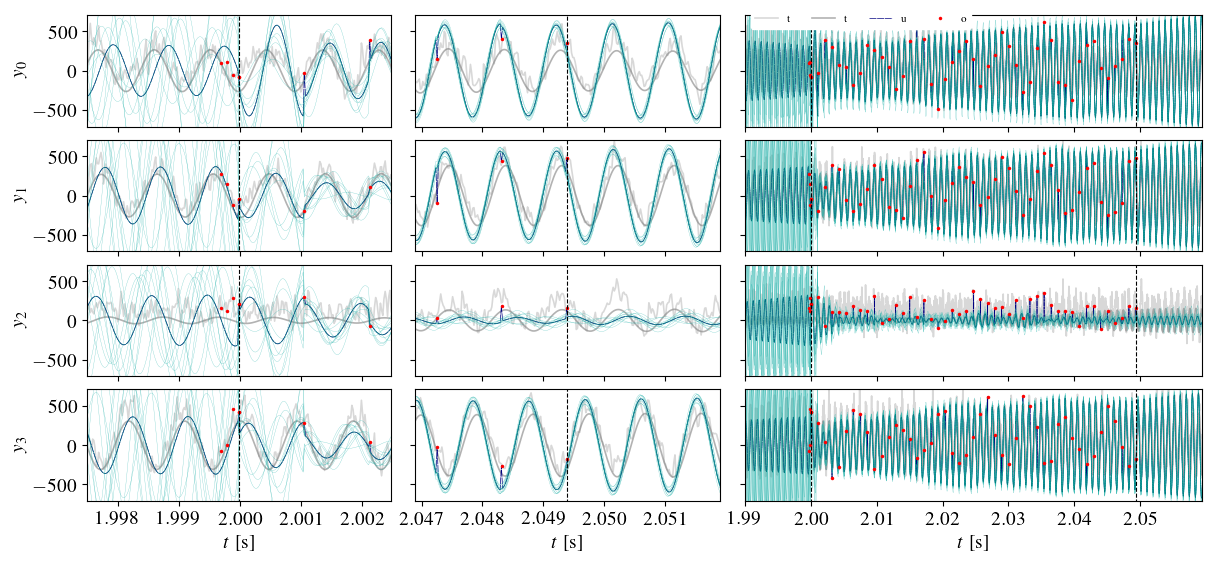

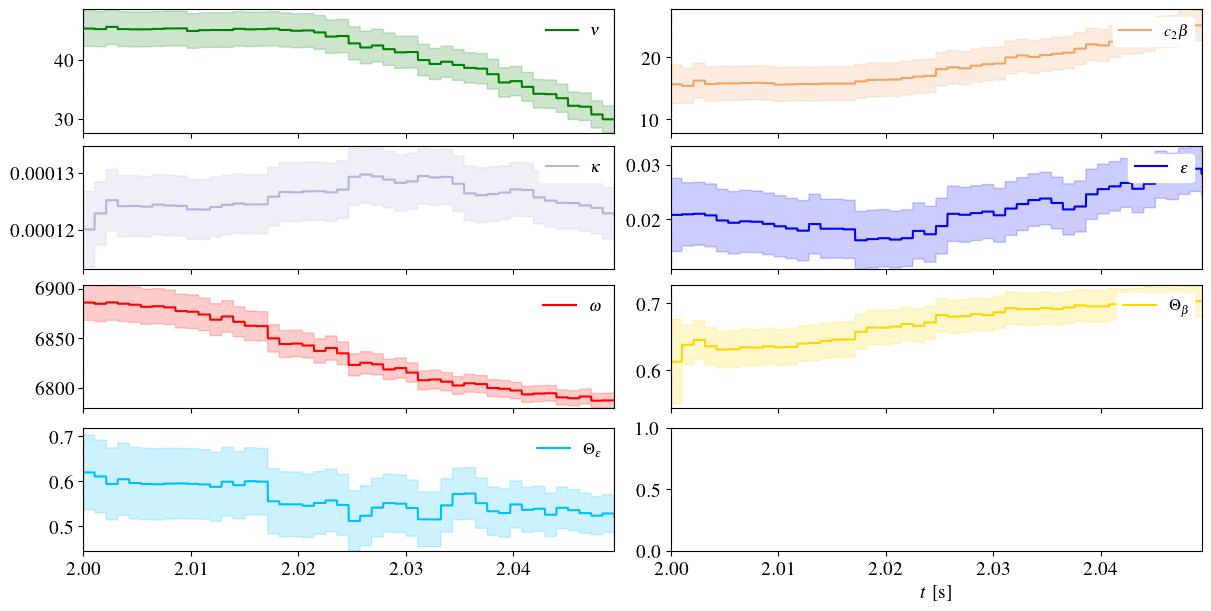

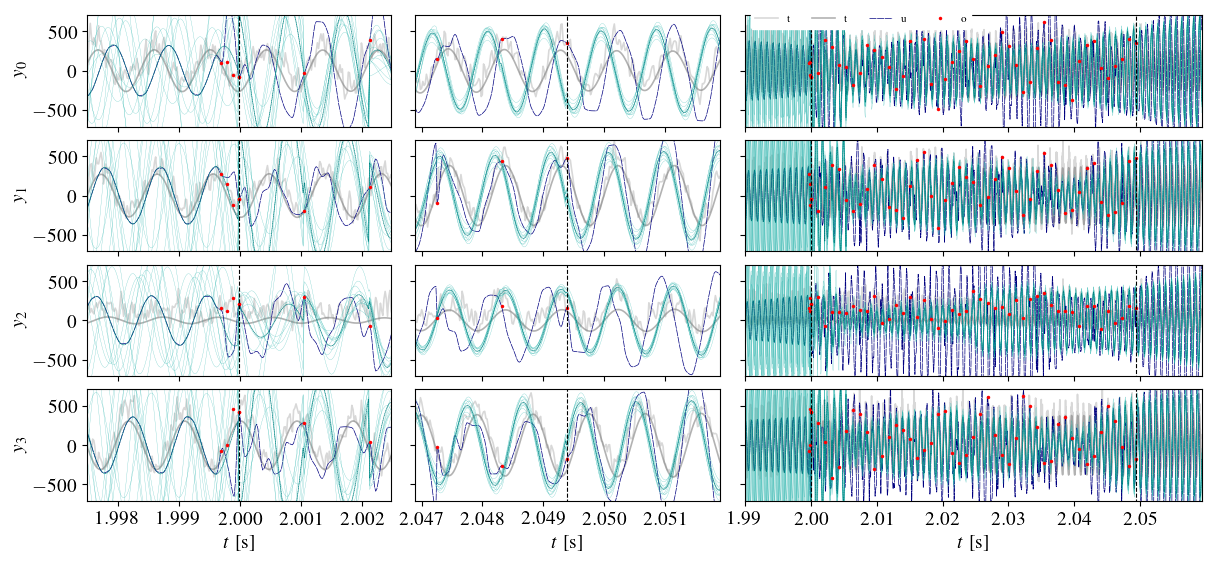

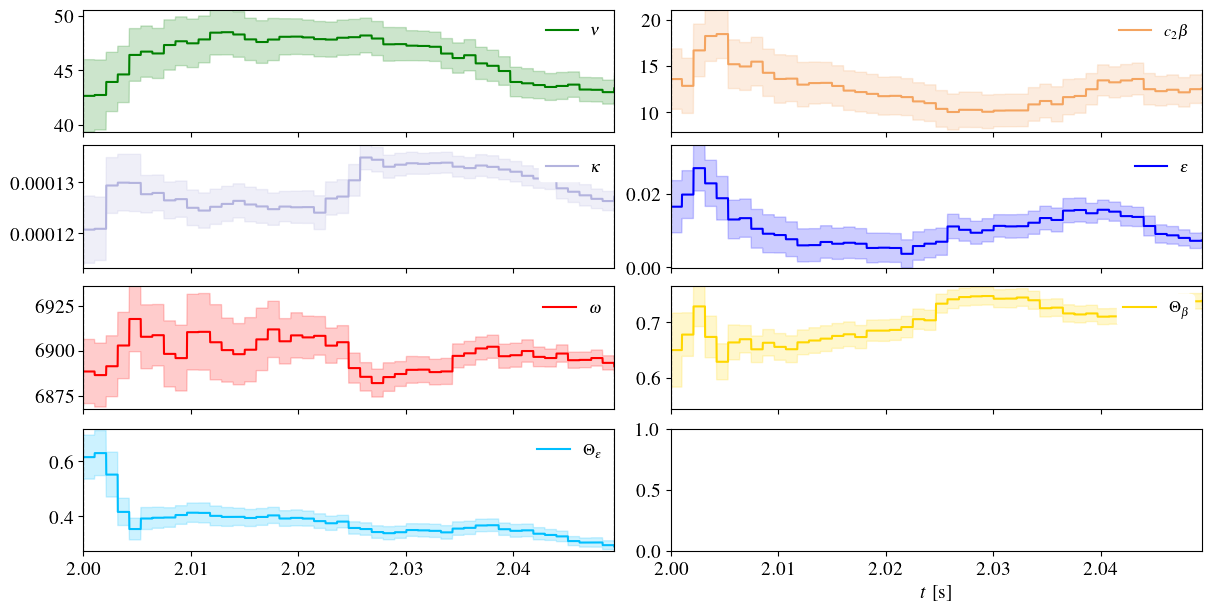

In [24]:
from essentials.plotResults import plot_timeseries, plot_parameters

truth = dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t,
             t_obs=t_true[obs_idx], y_obs=y_raw[obs_idx], dt_obs=dt_obs * dt_t,
             std_obs=std_obs, wash_t=wash_t, wash_obs=wash_obs)

for filter_ens in out:
    plot_timeseries(filter_ens, truth)
    plot_parameters(filter_ens, truth)